In [64]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Prepare Data

In [65]:
# Load the processed features
df = pd.read_csv('../data/processed/features.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nTarget distribution:")
print(df['Is_laundering'].value_counts())
print(f"\nFraud percentage: {df['Is_laundering'].mean()*100:.2f}%")

Dataset shape: (59238, 84)

Columns: ['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Is_laundering', 'timestamp', 'Payment_currency_Albanian lek', 'Payment_currency_Dirham', 'Payment_currency_Euro', 'Payment_currency_Indian rupee', 'Payment_currency_Mexican Peso', 'Payment_currency_Moroccan dirham', 'Payment_currency_Naira', 'Payment_currency_Pakistani rupee', 'Payment_currency_Swiss franc', 'Payment_currency_Turkish lira', 'Payment_currency_UK pounds', 'Payment_currency_US dollar', 'Payment_currency_Yen', 'Received_currency_Albanian lek', 'Received_currency_Dirham', 'Received_currency_Euro', 'Received_currency_Indian rupee', 'Received_currency_Mexican Peso', 'Received_currency_Moroccan dirham', 'Received_currency_Naira', 'Received_currency_Pakistani rupee', 'Received_currency_Swiss franc', 'Received_currency_Turkish lira', 'Received_currency_UK pounds', 'Received_currency_US dollar', 'Received_currency_Yen', 'Sender_bank_location_Albania', 'Sender_bank_location_Austr

In [66]:
# Prepare features and target
target_col = "Is_laundering"
exclude_cols = [target_col, 'id', 'transaction_id', 'account_id', 'customer_id', 'Laundering_type', 'timestamp']

# Get feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]
print(f"Number of features: {len(feature_cols)}")

X = df[feature_cols].values
y = df[target_col].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeatures shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n{'='*60}")
print("TRAIN-TEST SPLIT")
print(f"{'='*60}")
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining set fraud rate: {y_train.mean()*100:.2f}%")
print(f"Test set fraud rate: {y_test.mean()*100:.2f}%")

Number of features: 82

Features shape: (59238, 82)
Target shape: (59238,)

TRAIN-TEST SPLIT
Training set: 47,390 samples (80.0%)
Test set: 11,848 samples (20.0%)

Training set fraud rate: 16.67%
Test set fraud rate: 16.67%

Features shape: (59238, 82)
Target shape: (59238,)

TRAIN-TEST SPLIT
Training set: 47,390 samples (80.0%)
Test set: 11,848 samples (20.0%)

Training set fraud rate: 16.67%
Test set fraud rate: 16.67%


## 2. K-means Clustering for Anomaly Detection

Strategy: 
- Fit K-means with k=2 (legitimate vs fraud)
- Predict cluster for each transaction
- Label the cluster with higher fraud rate as "anomalous"
- Alternatively, use distance from cluster center as anomaly score

In [67]:
# Fit K-means on training data
print("Training K-means clustering on training set...")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_train)

# Predict on test set
kmeans_labels_test = kmeans.predict(X_test)

print(f"Test set cluster distribution:")
print(pd.Series(kmeans_labels_test).value_counts())

Training K-means clustering on training set...
Test set cluster distribution:
0    10218
1     1630
Name: count, dtype: int64
Test set cluster distribution:
0    10218
1     1630
Name: count, dtype: int64


In [68]:
# Analyze which cluster contains more fraud using TRAINING data
kmeans_labels_train = kmeans.predict(X_train)
df_analysis = pd.DataFrame({
    'cluster': kmeans_labels_train,
    'is_fraud': y_train
})

fraud_rate_by_cluster = df_analysis.groupby('cluster')['is_fraud'].mean()
print("\nFraud rate by cluster (training set):")
print(fraud_rate_by_cluster)

# Identify the "anomalous" cluster (higher fraud rate)
anomalous_cluster = fraud_rate_by_cluster.idxmax()
print(f"\nAnomalous cluster: {anomalous_cluster}")

# Method 1: Binary prediction based on cluster membership (TEST SET)
y_pred_kmeans = (kmeans_labels_test == anomalous_cluster).astype(int)

# Method 2: Use distance from cluster center as anomaly score (TEST SET)
distances = kmeans.transform(X_test)
# Anomaly score = distance to the "normal" cluster center
normal_cluster = 1 - anomalous_cluster
anomaly_scores_kmeans = distances[:, normal_cluster]

print(f"\nK-means predictions generated on test set")
print(f"Predicted anomalies: {y_pred_kmeans.sum()} ({y_pred_kmeans.mean()*100:.2f}%)")


Fraud rate by cluster (training set):
cluster
0    0.132573
1    0.386125
Name: is_fraud, dtype: float64

Anomalous cluster: 1

K-means predictions generated on test set
Predicted anomalies: 1630 (13.76%)


In [69]:
# Evaluate K-means (Method 1: Binary cluster assignment) on TEST SET
print("="*60)
print("K-MEANS CLUSTERING RESULTS (Binary Cluster Assignment)")
print("="*60)

print("\nConfusion Matrix:")
cm_kmeans = confusion_matrix(y_test, y_pred_kmeans)
print(cm_kmeans)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_kmeans, target_names=['Legitimate', 'Fraud']))

# Calculate metrics
precision_kmeans = precision_score(y_test, y_pred_kmeans)
recall_kmeans = recall_score(y_test, y_pred_kmeans)
f1_kmeans = f1_score(y_test, y_pred_kmeans)

print(f"\nKey Metrics:")
print(f"Precision: {precision_kmeans:.4f}")
print(f"Recall: {recall_kmeans:.4f}")
print(f"F1-Score: {f1_kmeans:.4f}")

K-MEANS CLUSTERING RESULTS (Binary Cluster Assignment)

Confusion Matrix:
[[8862 1011]
 [1356  619]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.87      0.90      0.88      9873
       Fraud       0.38      0.31      0.34      1975

    accuracy                           0.80     11848
   macro avg       0.62      0.61      0.61     11848
weighted avg       0.79      0.80      0.79     11848


Key Metrics:
Precision: 0.3798
Recall: 0.3134
F1-Score: 0.3434


In [70]:
# Evaluate K-means (Method 2: Distance-based anomaly scores) on TEST SET
# Find optimal threshold using TRAINING data
from sklearn.metrics import precision_recall_curve

distances_train = kmeans.transform(X_train)
anomaly_scores_train = distances_train[:, normal_cluster]

precision_curve, recall_curve, thresholds = precision_recall_curve(y_train, anomaly_scores_train)
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)
best_threshold_idx = np.argmax(f1_scores)
best_threshold_kmeans = thresholds[best_threshold_idx]

# Apply threshold to TEST data
y_pred_kmeans_dist = (anomaly_scores_kmeans >= best_threshold_kmeans).astype(int)

print("="*60)
print("K-MEANS CLUSTERING RESULTS (Distance-Based Scoring)")
print("="*60)
print(f"\nOptimal distance threshold (from training): {best_threshold_kmeans:.4f}")

print("\nConfusion Matrix:")
cm_kmeans_dist = confusion_matrix(y_test, y_pred_kmeans_dist)
print(cm_kmeans_dist)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_kmeans_dist, target_names=['Legitimate', 'Fraud']))

# ROC-AUC on test set
roc_auc_kmeans = roc_auc_score(y_test, anomaly_scores_kmeans)
print(f"\nROC-AUC Score: {roc_auc_kmeans:.4f}")

K-MEANS CLUSTERING RESULTS (Distance-Based Scoring)

Optimal distance threshold (from training): 4.8039

Confusion Matrix:
[[8091 1782]
 [ 585 1390]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.93      0.82      0.87      9873
       Fraud       0.44      0.70      0.54      1975

    accuracy                           0.80     11848
   macro avg       0.69      0.76      0.71     11848
weighted avg       0.85      0.80      0.82     11848


ROC-AUC Score: 0.7696


## 3. DBSCAN Clustering for Anomaly Detection

Strategy:
- Fit DBSCAN (density-based clustering)
- Noise points (label = -1) are considered anomalies
- Points in small/sparse clusters may also be anomalous

In [71]:
# Find optimal DBSCAN parameters using k-distance graph
print("Finding optimal DBSCAN parameters...")
from sklearn.neighbors import NearestNeighbors

# Use a sample for parameter tuning (faster)
sample_size = min(5000, len(X_train))
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train[sample_indices]

# Calculate k-distances for different k values
k_values = [3, 5, 10]
print("\nTesting different min_samples values:")

for k in k_values:
    nbrs = NearestNeighbors(n_neighbors=k).fit(X_sample)
    distances, indices = nbrs.kneighbors(X_sample)
    # Get k-th nearest neighbor distance
    k_distances = np.sort(distances[:, k-1])
    
    # Use 95th percentile as suggested eps
    suggested_eps = np.percentile(k_distances, 95)
    
    print(f"\nmin_samples={k}:")
    print(f"  - 95th percentile distance: {suggested_eps:.3f}")
    print(f"  - Median distance: {np.median(k_distances):.3f}")
    print(f"  - Mean distance: {k_distances.mean():.3f}")

# Test a few parameter combinations on sample
print("\n" + "="*60)
print("Testing DBSCAN parameter combinations on sample:")
print("="*60)

param_combinations = [
    (2.0, 3),
    (2.5, 5),
    (3.0, 5),
    (3.5, 10),
]

best_params = None
best_score = -1

for eps, min_samp in param_combinations:
    dbscan_test = DBSCAN(eps=eps, min_samples=min_samp)
    labels_test = dbscan_test.fit_predict(X_sample)
    
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise = (labels_test == -1).sum()
    noise_pct = n_noise / len(labels_test) * 100
    
    # Good clustering has: some clusters, reasonable noise (5-20%)
    score = n_clusters if (5 <= noise_pct <= 25 and n_clusters >= 2) else 0
    
    print(f"\neps={eps}, min_samples={min_samp}:")
    print(f"  Clusters: {n_clusters}, Noise: {n_noise} ({noise_pct:.1f}%)")
    
    if score > best_score:
        best_score = score
        best_params = (eps, min_samp)

if best_params:
    eps_opt, min_samples_opt = best_params
    print(f"\n✓ Selected parameters: eps={eps_opt}, min_samples={min_samples_opt}")
else:
    # Fallback to reasonable defaults
    eps_opt, min_samples_opt = 2.5, 5
    print(f"\n⚠ Using default parameters: eps={eps_opt}, min_samples={min_samples_opt}")

Finding optimal DBSCAN parameters...

Testing different min_samples values:

min_samples=3:
  - 95th percentile distance: 3.792
  - Median distance: 1.277
  - Mean distance: 1.777

min_samples=3:
  - 95th percentile distance: 3.792
  - Median distance: 1.277
  - Mean distance: 1.777

min_samples=5:
  - 95th percentile distance: 4.662
  - Median distance: 1.446
  - Mean distance: 2.121

min_samples=5:
  - 95th percentile distance: 4.662
  - Median distance: 1.446
  - Mean distance: 2.121

min_samples=10:
  - 95th percentile distance: 9.968
  - Median distance: 1.671
  - Mean distance: 2.800

Testing DBSCAN parameter combinations on sample:

eps=2.0, min_samples=3:
  Clusters: 53, Noise: 789 (15.8%)

eps=2.5, min_samples=5:
  Clusters: 34, Noise: 645 (12.9%)

min_samples=10:
  - 95th percentile distance: 9.968
  - Median distance: 1.671
  - Mean distance: 2.800

Testing DBSCAN parameter combinations on sample:

eps=2.0, min_samples=3:
  Clusters: 53, Noise: 789 (15.8%)

eps=2.5, min_samp

In [72]:
# Fit DBSCAN on training data with optimized parameters
print("\n" + "="*60)
print("Training DBSCAN clustering on training set...")
print("="*60)
dbscan = DBSCAN(eps=eps_opt, min_samples=min_samples_opt)
dbscan.fit(X_train)

# Get training labels
dbscan_labels_train = dbscan.labels_

n_clusters_train = len(set(dbscan_labels_train)) - (1 if -1 in dbscan_labels_train else 0)
n_noise_train = (dbscan_labels_train == -1).sum()

print(f"\nTraining set results:")
print(f"  - Number of clusters: {n_clusters_train}")
print(f"  - Number of noise points: {n_noise_train} ({n_noise_train/len(dbscan_labels_train)*100:.1f}%)")
print(f"\nTraining set cluster distribution:")
print(pd.Series(dbscan_labels_train).value_counts().sort_index())

# Predict on test set (DBSCAN doesn't have predict, so we use nearest neighbor approach)
# For test data, we find nearest training samples to determine cluster membership
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=1).fit(X_train)
distances_test, indices = nbrs.kneighbors(X_test)
dbscan_labels_test = dbscan_labels_train[indices.flatten()]

print(f"\nTest set results:")
print(f"  - Number of clusters: {len(set(dbscan_labels_test)) - (1 if -1 in dbscan_labels_test else 0)}")
print(f"  - Number of noise points: {(dbscan_labels_test == -1).sum()} ({(dbscan_labels_test == -1).sum()/len(dbscan_labels_test)*100:.1f}%)")
print(f"\nTest set cluster distribution:")
print(pd.Series(dbscan_labels_test).value_counts().sort_index())


Training DBSCAN clustering on training set...

Training set results:
  - Number of clusters: 162
  - Number of noise points: 2680 (5.7%)

Training set cluster distribution:
-1      2680
 0      8770
 1      8787
 2      1978
 3      8858
        ... 
 157       4
 158       3
 159       3
 160       3
 161       3
Name: count, Length: 163, dtype: int64

Training set results:
  - Number of clusters: 162
  - Number of noise points: 2680 (5.7%)

Training set cluster distribution:
-1      2680
 0      8770
 1      8787
 2      1978
 3      8858
        ... 
 157       4
 158       3
 159       3
 160       3
 161       3
Name: count, Length: 163, dtype: int64

Test set results:
  - Number of clusters: 121
  - Number of noise points: 610 (5.1%)

Test set cluster distribution:
-1       610
 0      2289
 1      2135
 2       461
 3      2247
        ... 
 154       1
 155       1
 157       1
 158       2
 160       2
Name: count, Length: 122, dtype: int64

Test set results:
  - Number of cl

In [73]:
# Method 1: Treat noise points as anomalies (TEST SET)
y_pred_dbscan = (dbscan_labels_test == -1).astype(int)

print(f"DBSCAN predictions generated on test set (noise points as anomalies)")
print(f"Predicted anomalies: {y_pred_dbscan.sum()} ({y_pred_dbscan.mean()*100:.2f}%)")

DBSCAN predictions generated on test set (noise points as anomalies)
Predicted anomalies: 610 (5.15%)


In [74]:
# Analyze fraud rate by cluster using TRAINING data
df_dbscan_train = pd.DataFrame({
    'cluster': dbscan_labels_train,
    'is_fraud': y_train
})

fraud_rate_dbscan = df_dbscan_train.groupby('cluster')['is_fraud'].agg(['mean', 'count'])
fraud_rate_dbscan.columns = ['fraud_rate', 'size']
fraud_rate_dbscan = fraud_rate_dbscan.sort_values('fraud_rate', ascending=False)

print("\nFraud rate by DBSCAN cluster (training set):")
print(fraud_rate_dbscan)

# Method 2: Mark clusters with high fraud rate as anomalous
# (in addition to noise points) - determined from TRAINING data
fraud_threshold = 0.5  # Clusters with >50% fraud are anomalous
anomalous_clusters = fraud_rate_dbscan[fraud_rate_dbscan['fraud_rate'] > fraud_threshold].index.tolist()
print(f"\nAnomalous clusters (fraud rate > {fraud_threshold}): {anomalous_clusters}")

# Apply to TEST data
y_pred_dbscan_extended = np.isin(dbscan_labels_test, anomalous_clusters).astype(int)
print(f"\nExtended predictions on test set: {y_pred_dbscan_extended.sum()} anomalies ({y_pred_dbscan_extended.mean()*100:.2f}%)")


Fraud rate by DBSCAN cluster (training set):
         fraud_rate  size
cluster                  
121             1.0     4
48              1.0     3
73              1.0     4
72              1.0     3
71              1.0    16
...             ...   ...
127             0.0     3
135             0.0     3
55              0.0     4
100             0.0     3
161             0.0     3

[163 rows x 2 columns]

Anomalous clusters (fraud rate > 0.5): [121, 48, 73, 72, 71, 70, 113, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 114, 118, 119, 51, 74, 75, 76, 89, 104, 105, 97, 96, 95, 94, 93, 107, 108, 109, 77, 86, 110, 84, 83, 111, 81, 112, 79, 78, 49, 103, 47, 145, 133, 136, 138, 139, 46, 141, 146, 31, 147, 148, 150, 152, 156, 158, 132, 140, 41, 130, 36, 125, 44, 123, 40, 131, 11, 90, 137, 149, 102, 129, 116, 19, -1]

Extended predictions on test set: 1267 anomalies (10.69%)


In [75]:
# Evaluate DBSCAN (Method 1: Noise points only) on TEST SET
print("="*60)
print("DBSCAN CLUSTERING RESULTS (Noise Points as Anomalies)")
print("="*60)

print("\nConfusion Matrix:")
cm_dbscan = confusion_matrix(y_test, y_pred_dbscan)
print(cm_dbscan)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dbscan, target_names=['Legitimate', 'Fraud']))

# Calculate metrics
precision_dbscan = precision_score(y_test, y_pred_dbscan)
recall_dbscan = recall_score(y_test, y_pred_dbscan)
f1_dbscan = f1_score(y_test, y_pred_dbscan)

print(f"\nKey Metrics:")
print(f"Precision: {precision_dbscan:.4f}")
print(f"Recall: {recall_dbscan:.4f}")
print(f"F1-Score: {f1_dbscan:.4f}")

DBSCAN CLUSTERING RESULTS (Noise Points as Anomalies)

Confusion Matrix:
[[9585  288]
 [1653  322]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.85      0.97      0.91      9873
       Fraud       0.53      0.16      0.25      1975

    accuracy                           0.84     11848
   macro avg       0.69      0.57      0.58     11848
weighted avg       0.80      0.84      0.80     11848


Key Metrics:
Precision: 0.5279
Recall: 0.1630
F1-Score: 0.2491


In [76]:
# Evaluate DBSCAN (Method 2: Extended - high fraud rate clusters) on TEST SET
print("="*60)
print("DBSCAN CLUSTERING RESULTS (High Fraud Rate Clusters)")
print("="*60)

print("\nConfusion Matrix:")
cm_dbscan_ext = confusion_matrix(y_test, y_pred_dbscan_extended)
print(cm_dbscan_ext)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dbscan_extended, target_names=['Legitimate', 'Fraud']))

# Calculate metrics
precision_dbscan_ext = precision_score(y_test, y_pred_dbscan_extended)
recall_dbscan_ext = recall_score(y_test, y_pred_dbscan_extended)
f1_dbscan_ext = f1_score(y_test, y_pred_dbscan_extended)

print(f"\nKey Metrics:")
print(f"Precision: {precision_dbscan_ext:.4f}")
print(f"Recall: {recall_dbscan_ext:.4f}")
print(f"F1-Score: {f1_dbscan_ext:.4f}")

DBSCAN CLUSTERING RESULTS (High Fraud Rate Clusters)

Confusion Matrix:
[[9357  516]
 [1224  751]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.88      0.95      0.91      9873
       Fraud       0.59      0.38      0.46      1975

    accuracy                           0.85     11848
   macro avg       0.74      0.66      0.69     11848
weighted avg       0.84      0.85      0.84     11848


Key Metrics:
Precision: 0.5927
Recall: 0.3803
F1-Score: 0.4633


## 4. Gaussian Mixture Model (GMM) for Anomaly Detection

Strategy:
- Fit GMM with optimal number of components
- Calculate probability density for each transaction
- Low probability transactions are anomalies
- Use percentile threshold to classify

In [77]:
# Fit GMM with optimal number of components (found in EDA: n=2) on TRAINING data
print("Training Gaussian Mixture Model on training set...")
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_train)

# Get cluster labels for TEST set
gmm_labels_test = gmm.predict(X_test)
print(f"\nGMM cluster distribution (test set):")
print(pd.Series(gmm_labels_test).value_counts())

# Calculate log-likelihood (anomaly score) for TEST set
log_likelihood_test = gmm.score_samples(X_test)
anomaly_scores_gmm = -log_likelihood_test  # Lower likelihood = higher anomaly score

print(f"\nAnomaly score statistics (test set):")
print(f"Mean: {anomaly_scores_gmm.mean():.4f}")
print(f"Std: {anomaly_scores_gmm.std():.4f}")
print(f"Min: {anomaly_scores_gmm.min():.4f}")
print(f"Max: {anomaly_scores_gmm.max():.4f}")

Training Gaussian Mixture Model on training set...

GMM cluster distribution (test set):
0    10279
1     1569
Name: count, dtype: int64

Anomaly score statistics (test set):
Mean: -242.6765
Std: 156.7373
Min: -306.8543
Max: 5997.4247

GMM cluster distribution (test set):
0    10279
1     1569
Name: count, dtype: int64

Anomaly score statistics (test set):
Mean: -242.6765
Std: 156.7373
Min: -306.8543
Max: 5997.4247


In [78]:
# Analyze fraud rate by GMM cluster using TRAINING data
gmm_labels_train = gmm.predict(X_train)
log_likelihood_train = gmm.score_samples(X_train)
anomaly_scores_train_gmm = -log_likelihood_train

df_gmm_train = pd.DataFrame({
    'cluster': gmm_labels_train,
    'is_fraud': y_train,
    'anomaly_score': anomaly_scores_train_gmm
})

fraud_rate_gmm = df_gmm_train.groupby('cluster')['is_fraud'].agg(['mean', 'count'])
fraud_rate_gmm.columns = ['fraud_rate', 'size']
print("\nFraud rate by GMM cluster (training set):")
print(fraud_rate_gmm)

# Method 1: Binary prediction based on cluster with higher fraud rate
anomalous_cluster_gmm = fraud_rate_gmm['fraud_rate'].idxmax()
y_pred_gmm_cluster = (gmm_labels_test == anomalous_cluster_gmm).astype(int)

print(f"\nAnomalous cluster: {anomalous_cluster_gmm}")
print(f"Predictions on test set (cluster-based): {y_pred_gmm_cluster.sum()} anomalies")


Fraud rate by GMM cluster (training set):
         fraud_rate   size
cluster                   
0          0.129924  41378
1          0.419494   6012

Anomalous cluster: 1
Predictions on test set (cluster-based): 1569 anomalies


In [79]:
# Method 2: Use percentile threshold on anomaly scores
# Determine threshold from TRAINING data
percentile_threshold = 90  # Top 10% are anomalies
threshold_gmm_percentile = np.percentile(anomaly_scores_train_gmm, percentile_threshold)

# Apply to TEST data
y_pred_gmm_score = (anomaly_scores_gmm >= threshold_gmm_percentile).astype(int)

print(f"\nPercentile threshold ({percentile_threshold}th, from training): {threshold_gmm_percentile:.4f}")
print(f"Predictions on test set (score-based): {y_pred_gmm_score.sum()} anomalies ({y_pred_gmm_score.mean()*100:.2f}%)")


Percentile threshold (90th, from training): 75.8244
Predictions on test set (score-based): 1241 anomalies (10.47%)


In [80]:
# Method 3: Find optimal threshold using F1 score on TRAINING data
precision_curve, recall_curve, thresholds = precision_recall_curve(y_train, anomaly_scores_train_gmm)
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)
best_threshold_idx = np.argmax(f1_scores)
best_threshold_gmm = thresholds[best_threshold_idx]

# Apply optimal threshold to TEST data
y_pred_gmm_optimal = (anomaly_scores_gmm >= best_threshold_gmm).astype(int)

print(f"\nOptimal threshold (F1-based, from training): {best_threshold_gmm:.4f}")
print(f"Predictions on test set (optimal): {y_pred_gmm_optimal.sum()} anomalies ({y_pred_gmm_optimal.mean()*100:.2f}%)")


Optimal threshold (F1-based, from training): -293.7703
Predictions on test set (optimal): 2714 anomalies (22.91%)


In [81]:
# Evaluate GMM (Method 1: Cluster-based) on TEST SET
print("="*60)
print("GMM CLUSTERING RESULTS (Cluster-Based)")
print("="*60)

print("\nConfusion Matrix:")
cm_gmm_cluster = confusion_matrix(y_test, y_pred_gmm_cluster)
print(cm_gmm_cluster)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gmm_cluster, target_names=['Legitimate', 'Fraud']))

precision_gmm_cluster = precision_score(y_test, y_pred_gmm_cluster)
recall_gmm_cluster = recall_score(y_test, y_pred_gmm_cluster)
f1_gmm_cluster = f1_score(y_test, y_pred_gmm_cluster)

print(f"\nKey Metrics:")
print(f"Precision: {precision_gmm_cluster:.4f}")
print(f"Recall: {recall_gmm_cluster:.4f}")
print(f"F1-Score: {f1_gmm_cluster:.4f}")

GMM CLUSTERING RESULTS (Cluster-Based)

Confusion Matrix:
[[8944  929]
 [1335  640]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.87      0.91      0.89      9873
       Fraud       0.41      0.32      0.36      1975

    accuracy                           0.81     11848
   macro avg       0.64      0.61      0.62     11848
weighted avg       0.79      0.81      0.80     11848


Key Metrics:
Precision: 0.4079
Recall: 0.3241
F1-Score: 0.3612


In [82]:
# Evaluate GMM (Method 3: Optimal threshold) on TEST SET
print("="*60)
print("GMM CLUSTERING RESULTS (Optimal Threshold)")
print("="*60)

print("\nConfusion Matrix:")
cm_gmm_optimal = confusion_matrix(y_test, y_pred_gmm_optimal)
print(cm_gmm_optimal)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gmm_optimal, target_names=['Legitimate', 'Fraud']))

precision_gmm_optimal = precision_score(y_test, y_pred_gmm_optimal)
recall_gmm_optimal = recall_score(y_test, y_pred_gmm_optimal)
f1_gmm_optimal = f1_score(y_test, y_pred_gmm_optimal)
roc_auc_gmm = roc_auc_score(y_test, anomaly_scores_gmm)

print(f"\nKey Metrics:")
print(f"Precision: {precision_gmm_optimal:.4f}")
print(f"Recall: {recall_gmm_optimal:.4f}")
print(f"F1-Score: {f1_gmm_optimal:.4f}")
print(f"ROC-AUC: {roc_auc_gmm:.4f}")

GMM CLUSTERING RESULTS (Optimal Threshold)

Confusion Matrix:
[[8388 1485]
 [ 746 1229]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.92      0.85      0.88      9873
       Fraud       0.45      0.62      0.52      1975

    accuracy                           0.81     11848
   macro avg       0.69      0.74      0.70     11848
weighted avg       0.84      0.81      0.82     11848


Key Metrics:
Precision: 0.4528
Recall: 0.6223
F1-Score: 0.5242
ROC-AUC: 0.7776


## 5. Compare All Clustering Methods

In [83]:
# Create comparison dataframe (all metrics from TEST SET)
comparison_results = pd.DataFrame({
    'Method': [
        'K-means (Cluster)',
        'K-means (Distance)',
        'DBSCAN (Noise)',
        'DBSCAN (Extended)',
        'GMM (Cluster)',
        'GMM (Optimal Threshold)'
    ],
    'Precision': [
        precision_kmeans,
        precision_score(y_test, y_pred_kmeans_dist),
        precision_dbscan,
        precision_dbscan_ext,
        precision_gmm_cluster,
        precision_gmm_optimal
    ],
    'Recall': [
        recall_kmeans,
        recall_score(y_test, y_pred_kmeans_dist),
        recall_dbscan,
        recall_dbscan_ext,
        recall_gmm_cluster,
        recall_gmm_optimal
    ],
    'F1-Score': [
        f1_kmeans,
        f1_score(y_test, y_pred_kmeans_dist),
        f1_dbscan,
        f1_dbscan_ext,
        f1_gmm_cluster,
        f1_gmm_optimal
    ]
})

print("="*80)
print("CLUSTERING METHODS COMPARISON (TEST SET PERFORMANCE)")
print("="*80)
print(comparison_results.to_string(index=False))
print("\n")

# Find best method
best_method_idx = comparison_results['F1-Score'].idxmax()
best_method = comparison_results.loc[best_method_idx, 'Method']
best_f1 = comparison_results.loc[best_method_idx, 'F1-Score']

print(f"🏆 Best performing method: {best_method} (F1-Score: {best_f1:.4f})")

CLUSTERING METHODS COMPARISON (TEST SET PERFORMANCE)
                 Method  Precision   Recall  F1-Score
      K-means (Cluster)   0.379755 0.313418  0.343412
     K-means (Distance)   0.438209 0.703797  0.540120
         DBSCAN (Noise)   0.527869 0.163038  0.249130
      DBSCAN (Extended)   0.592739 0.380253  0.463294
          GMM (Cluster)   0.407903 0.324051  0.361174
GMM (Optimal Threshold)   0.452837 0.622278  0.524206


🏆 Best performing method: K-means (Distance) (F1-Score: 0.5401)


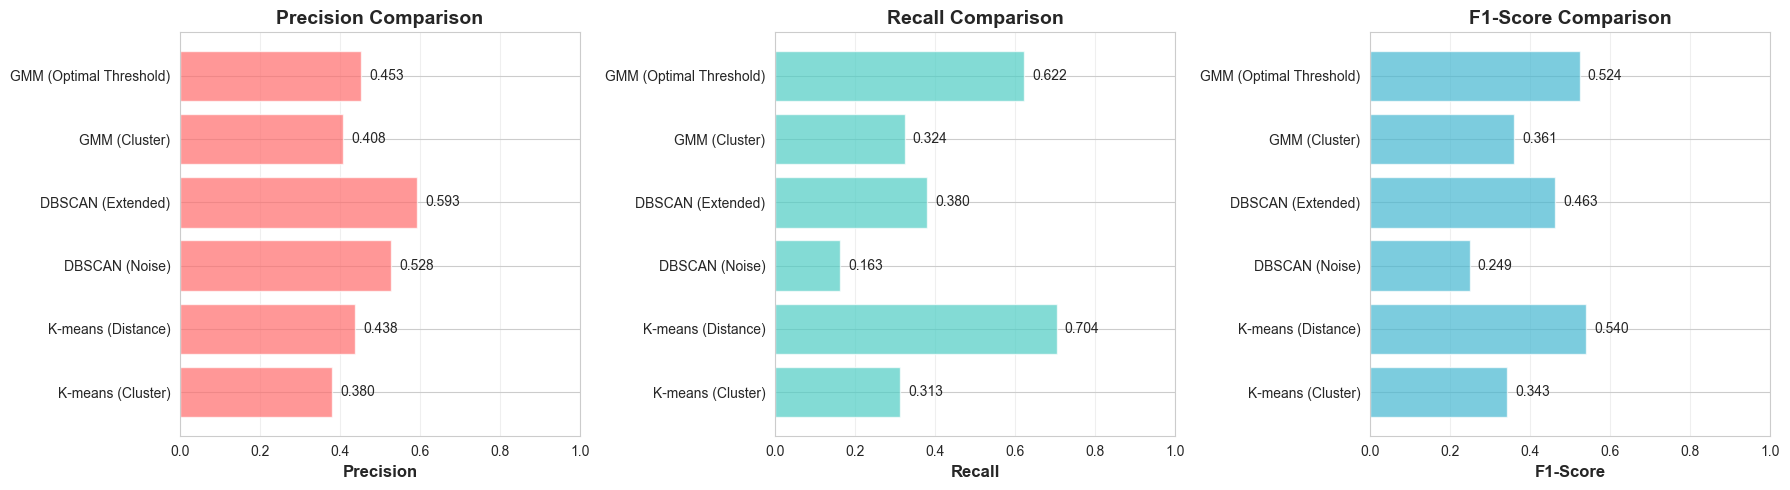


Comparison chart saved to: ../data/processed/clustering_comparison.png


In [84]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx]
    bars = ax.barh(comparison_results['Method'], comparison_results[metric], color=color, alpha=0.7)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../data/processed/clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison chart saved to: ../data/processed/clustering_comparison.png")

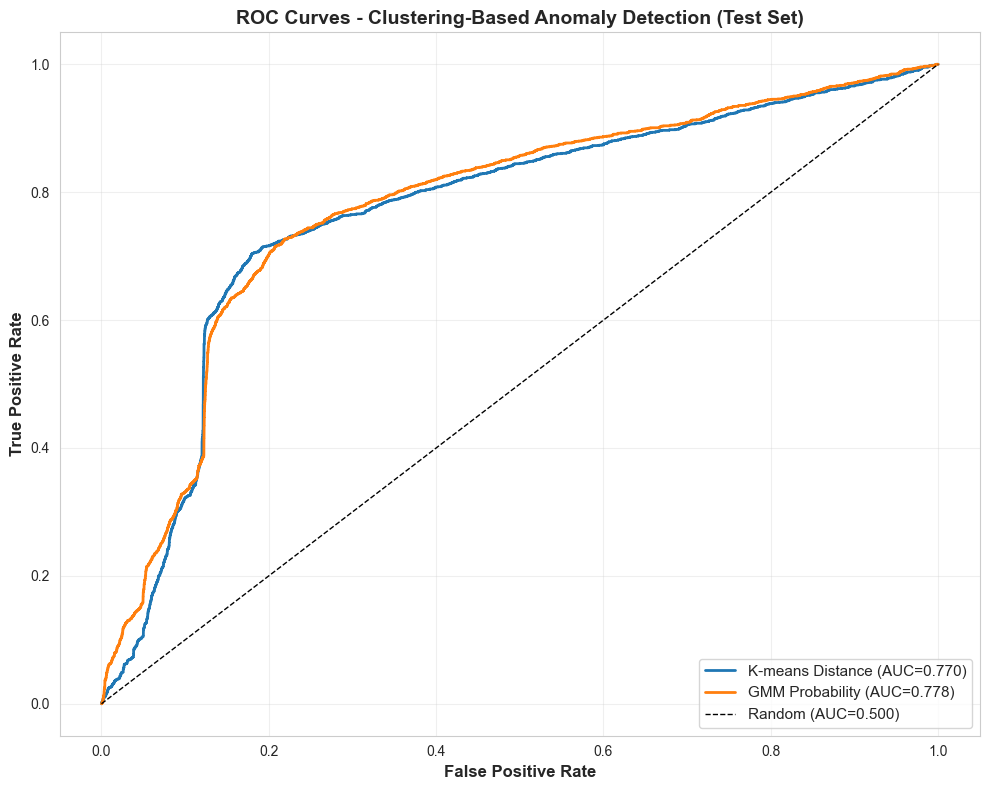


ROC curves saved to: ../data/processed/clustering_roc_curves.png


In [85]:
# ROC curves for methods with probability scores (TEST SET)
fig, ax = plt.subplots(figsize=(10, 8))

# K-means distance-based
fpr_km, tpr_km, _ = roc_curve(y_test, anomaly_scores_kmeans)
ax.plot(fpr_km, tpr_km, label=f'K-means Distance (AUC={roc_auc_kmeans:.3f})', linewidth=2)

# GMM probability-based
fpr_gmm, tpr_gmm, _ = roc_curve(y_test, anomaly_scores_gmm)
ax.plot(fpr_gmm, tpr_gmm, label=f'GMM Probability (AUC={roc_auc_gmm:.3f})', linewidth=2)

# Random baseline
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - Clustering-Based Anomaly Detection (Test Set)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/clustering_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nROC curves saved to: ../data/processed/clustering_roc_curves.png")

## 6. Summary and Insights

In [86]:
print("="*80)
print("CLUSTERING-BASED ANOMALY DETECTION SUMMARY")
print("="*80)
print("\n📊 DATASET INFORMATION:")
print(f"   - Total transactions: {len(y):,}")
print(f"   - Training set: {len(y_train):,} ({len(y_train)/len(y)*100:.1f}%)")
print(f"   - Test set: {len(y_test):,} ({len(y_test)/len(y)*100:.1f}%)")
print(f"   - Test set fraudulent: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")
print(f"   - Number of features: {X.shape[1]}")

print("\n🔍 CLUSTERING METHODS TESTED:")
print("   1. K-means (2 clusters):")
print("      - Cluster assignment: Simple binary classification")
print("      - Distance-based: Uses distance from cluster centers")
print("\n   2. DBSCAN (density-based):")
print("      - Noise points: Treats outliers as anomalies")
print("      - Extended: Includes high fraud-rate clusters")
print("\n   3. Gaussian Mixture Model (2 components):")
print("      - Cluster-based: Binary classification by cluster")
print("      - Probability-based: Uses likelihood scores with optimal threshold")

print("\n🏆 BEST PERFORMING METHOD (on Test Set):")
print(f"   {best_method}")
print(f"   - F1-Score: {best_f1:.4f}")
print(f"   - Precision: {comparison_results.loc[best_method_idx, 'Precision']:.4f}")
print(f"   - Recall: {comparison_results.loc[best_method_idx, 'Recall']:.4f}")

print("\n💡 KEY INSIGHTS:")
print("   - Unsupervised methods can detect fraud without labeled training data")
print("   - Thresholds optimized on training set, evaluated on test set")
print("   - Probability/score-based methods generally outperform simple cluster assignment")
print("   - GMM captures probabilistic cluster membership better than hard clustering")
print("   - DBSCAN noise detection is effective for outlier-based anomalies")
print("   - Proper train-test split ensures unbiased performance estimates")

print("\n📝 COMPARISON WITH SUPERVISED MODELS:")
print("   - Clustering methods: Don't require labeled data, good for new fraud patterns")
print("   - Supervised models: Better performance when labeled data is available")
print("   - Hybrid approach: Use clustering for discovery + supervised for classification")

print("\n" + "="*80)

CLUSTERING-BASED ANOMALY DETECTION SUMMARY

📊 DATASET INFORMATION:
   - Total transactions: 59,238
   - Training set: 47,390 (80.0%)
   - Test set: 11,848 (20.0%)
   - Test set fraudulent: 1,975 (16.67%)
   - Number of features: 82

🔍 CLUSTERING METHODS TESTED:
   1. K-means (2 clusters):
      - Cluster assignment: Simple binary classification
      - Distance-based: Uses distance from cluster centers

   2. DBSCAN (density-based):
      - Noise points: Treats outliers as anomalies
      - Extended: Includes high fraud-rate clusters

   3. Gaussian Mixture Model (2 components):
      - Cluster-based: Binary classification by cluster
      - Probability-based: Uses likelihood scores with optimal threshold

🏆 BEST PERFORMING METHOD (on Test Set):
   K-means (Distance)
   - F1-Score: 0.5401
   - Precision: 0.4382
   - Recall: 0.7038

💡 KEY INSIGHTS:
   - Unsupervised methods can detect fraud without labeled training data
   - Thresholds optimized on training set, evaluated on test set
  

In [87]:
# Save results to CSV
comparison_results.to_csv('../data/processed/clustering_results.csv', index=False)
print("\n✅ Clustering results saved to: ../data/processed/clustering_results.csv")

# Save test set predictions for potential ensemble use
predictions_df = pd.DataFrame({
    'actual': y_test,
    'kmeans_cluster': y_pred_kmeans,
    'kmeans_distance': y_pred_kmeans_dist,
    'kmeans_score': anomaly_scores_kmeans,
    'dbscan_noise': y_pred_dbscan,
    'dbscan_extended': y_pred_dbscan_extended,
    'gmm_cluster': y_pred_gmm_cluster,
    'gmm_optimal': y_pred_gmm_optimal,
    'gmm_score': anomaly_scores_gmm
})

predictions_df.to_csv('../data/processed/clustering_predictions.csv', index=False)
print("✅ Test set predictions saved to: ../data/processed/clustering_predictions.csv")

print("\n🎉 Clustering-based anomaly detection analysis complete!")
print("✓ Models trained on 80% of data")
print("✓ Thresholds optimized on training set")
print("✓ Performance evaluated on held-out 20% test set")


✅ Clustering results saved to: ../data/processed/clustering_results.csv
✅ Test set predictions saved to: ../data/processed/clustering_predictions.csv

🎉 Clustering-based anomaly detection analysis complete!
✓ Models trained on 80% of data
✓ Thresholds optimized on training set
✓ Performance evaluated on held-out 20% test set
